In [1]:
import pandas as pd
import pickle
import numpy as np
from datetime import datetime, timedelta
from EM import EM
import matplotlib.pyplot as plt
from plot import plot

### TO DO
* Don't drop all the treatments before the first measurements. Depending on how far we want to look back (another thing to specify), keep the relevant ones

In [2]:
cdm_t = pd.read_pickle('../Data/cdm_t.pkl')
cdm_s = pd.read_pickle('../Data/cdm_s.pkl')

### Data Query Specification

In [3]:
# store signal names and their matching contexts
# key: signal name, e.g. inr
# value: (treatment_names, chronic_keywords, demographic_names)
# treatment_names: dict, key: treatment category e.g. anticoagulant, value: list of relevant fields, e.g. warfarin_dose
# chronic keywords: list, e.g. liver disease
# each signal is specified by a block of cell
signal_context = {}

In [4]:
signal_name = 'inr'

treatment_names = {}
treatment_names['nsaid'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['anticoagulant'] = ['warfarin_dose','heparin_dose','dabigatran_dose','edoxaban_dose','rivaroxaban_dose',
'apixaban_dose','enoxaparin_dose','dalteparin_dose','fondaparinux_dose']
treatment_names['transfusion_plasma'] = ['transfuse_plasma']
treatment_names['transfusion_platelets'] = ['transfuse_platelets']
treatment_names['aspirin'] = ['aspirin_dose']

# chronic dict is keyed on the keywords of the chronic conditions we care about
# the keywords are specified in chronic_keywords
# the value is a list of all the features in cdm_s that contain that keyword
chronic_keywords = ['liver_disease', 'sickle_cell']

demographic_names = ['age']

signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [78]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['interference_drugs'] = ['dronedarone_dose', 'trimethoprim_dose']
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['ace_i'] = ['lisinopril_dose',
 'ramipril_dose',
 'benazepril_dose',
 'enalaprilat_dose',
 'captopril_dose',
 'perindopril_dose',
 'trandolapril_dose']
treatment_names['arb'] = ['valsartan_dose',
 'telmisartan_dose',
 'irbesartan_dose',
 'losartan_dose',
 'candesartan_dose']

#treatment_names['search'] = ['losartan']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'sickle_cell', 'renal', 'esrd', 'diabetes', 'heart_failure']

demographic_names = ['age', 'gender', 'admit_weight']

In [6]:
# fill in chronic name dict by finding all the relevant fields available in cdm_s for each chronic keyword
chronic_names = {}
all_chronic = cdm_s.loc[:, 'fid'].unique()
for name in chronic_keywords:
    chronic_names[name] = [s for s in all_chronic if name in s]

In [7]:
chronic_names

{'chronic_kidney': ['chronic_kidney_final_diag',
  'chronic_kidney_hist',
  'chronic_kidney_diag',
  'chronic_kidney_prob'],
 'kidney_cancer': ['kidney_cancer_icd9_prob',
  'kidney_cancer_icd9_hist',
  'kidney_cancer_icd9_diag'],
 'sickle_cell': ['sickle_cell_trait_final_diag',
  'sickle_cell_trait_hist',
  'sickle_cell_wo_crisis_hist',
  'sickle_cell_crisis_final_diag',
  'sickle_cell_crisis_prob',
  'sickle_cell_wo_crisis_diag',
  'sickle_cell_wo_crisis_final_diag',
  'sickle_cell_trait_prob',
  'sickle_cell_crisis_diag',
  'sickle_cell_crisis_hist',
  'sickle_cell_wo_crisis_prob',
  'sickle_cell_trait_diag'],
 'renal': ['renal_insufficiency_hist', 'renal_insufficiency_diag'],
 'esrd': ['esrd_final_diag', 'esrd_hist', 'esrd_prob', 'esrd_diag'],
 'diabetes': ['diabetes_hist', 'diabetes_diag'],
 'heart_failure': ['heart_failure_hist', 'heart_failure_diag']}

In [79]:
# helper to find the fields available in cdm_t corresponding to a list of potentially relevant fields
# specified in treatment_names['search']
all_features = cdm_t['fid'].unique()
def find_avai_feats():
    feat_list = []
    for feat in all_features:
        for name in treatment_names['search']:
            if name in feat:
                feat_list.append(feat)
    return feat_list

### Preprocessing Parameters

In [9]:
# the least number of signal observation a patient needs to have to be included
cutoff = 5

# bin_size is a offset alias used by the resample method
bin_size = '12H'
bin_size_num = 12

# the maximum percent of missingness allowed in observations for each individual
max_missing_pct = .4
# least number of training observations allowed for each individual
# (number of training observation is calculated based on the training pct specified below)
num_training_obs = 4

# number of past time points where treatment effects are considered
num_past_effects = 4

### Model Training Parameters

In [10]:
# EM Setting
training_pct = .8
single_effect = False

In [11]:
# put all the treatment names into a list to get the corresponding columns
treatment_list = []
for name in treatment_names.values():
    treatment_list.append(name)
# flatten the list
treatment_list = [item for sublist in treatment_list for item in sublist]

### Preprocessing

In [12]:
# df_t is part of the original dataframe that has all the ids who have measurements for the signal we are interested 
# in
signal = cdm_t.loc[cdm_t.loc[:, 'fid'] == signal_name, 'value']
ids = np.unique(cdm_t.loc[signal.index, 'enc_id'])
df_t = cdm_t.loc[cdm_t.loc[:, 'enc_id'].isin(ids), :]

In [13]:
# df_t is now part of the dataframe that contains only the rows with fid being either the signal or the treatments
df_t = df_t.loc[df_t.loc[:, 'fid'].isin(treatment_list + [signal_name]), :]

In [14]:
df_t.head(10)

,dataset_id,enc_id,tsp,fid,value,confidence
129,3,5,2016-01-11 11:38:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2016-01-11 11:31:...",1
225,3,5,2016-01-11 17:46:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2016-01-11 11:31:...",1
240,3,5,2016-01-12 00:32:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2016-01-11 11:31:...",1
265,3,5,2016-01-12 07:58:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2016-01-11 11:31:...",1
270,3,5,2016-01-12 14:47:00+00,ibuprofen_dose,"{""dose"": 600.0, ""order_tsp"": ""2016-01-11 11:31...",1
277,3,5,2016-01-12 16:17:00+00,acetaminophen_dose,"{""dose"": 1000.0, ""order_tsp"": ""2016-01-11 14:1...",1
284,3,5,2016-01-12 21:03:00+00,ibuprofen_dose,"{""dose"": 600.0, ""order_tsp"": ""2016-01-11 11:31...",1
285,3,5,2016-01-12 23:57:00+00,acetaminophen_dose,"{""dose"": 1000.0, ""order_tsp"": ""2016-01-11 14:1...",1
286,3,5,2016-01-13 02:58:00+00,ibuprofen_dose,"{""dose"": 600.0, ""order_tsp"": ""2016-01-11 11:31...",1
287,3,5,2016-01-13 06:03:00+00,acetaminophen_dose,"{""dose"": 1000.0, ""order_tsp"": ""2016-01-11 14:1...",1


In [15]:
# convert tsp field to python datetime object
df_t.loc[:, 'tsp'] = df_t.loc[:, 'tsp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+%f'))
#df_t.loc[:, 'tsp'] = df_t.groupby('enc_id')['tsp'].apply(lambda x: x - x.iloc[0])

In [16]:
# for each id, adjust tsp so that time is zero for the first time the signal is measured
adjusted_time = df_t.groupby('enc_id').apply(lambda x: x.loc[:, 'tsp'] - x.loc[x.loc[:, 'fid'] == signal_name, 'tsp'].iloc[0])
# adjusted_time is multiindexed, need to drop one level before assigning it to column tsp
adjusted_time.index = adjusted_time.index.droplevel()
df_t.loc[:, 'tsp_adjusted'] = adjusted_time

In [17]:
# cut the dataframe based on a cutoff number on the number of signal measurement a patient has
keep_index = df_t.groupby('enc_id')['fid'].filter(lambda x: x.value_counts().loc[signal_name] >= cutoff).index
df_t_cut = df_t.loc[keep_index].copy()

In [18]:
# number of patient available after the cutoff
df_t_cut['enc_id'].unique().shape[0]

11773

In [19]:
# delete rows whose adjusted time is less than the earliest treatment effect we wish to consider
df_t_cut = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(hours=-num_past_effects*bin_size_num), :]

In [20]:
# delete rows before the first observation
#df_t_cut = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(), :]

#adjusted_time = df_t_cut.groupby('enc_id').apply(lambda x: x.loc[:, 'tsp_adjusted']-x.loc[:, 'tsp_adjusted'].iloc[0])
#adjusted_time.index = adjusted_time.index.droplevel()
#df_t_cut.loc[:, 'tsp_adjusted'] = adjusted_time

In [21]:
df_t_cut.head(10)

,dataset_id,enc_id,tsp,fid,value,confidence,tsp_adjusted
15876,3,177,2014-05-02 17:32:00,creatinine,1.1,1,0 days 00:00:00
15945,3,177,2014-05-03 06:25:00,creatinine,1.4,1,0 days 12:53:00
16022,3,177,2014-05-04 06:45:00,creatinine,1.0,1,1 days 13:13:00
16107,3,177,2014-05-05 04:49:00,creatinine,0.9,1,2 days 11:17:00
16199,3,177,2014-05-06 12:58:00,creatinine,0.9,1,3 days 19:26:00
16244,3,177,2014-05-07 05:55:00,creatinine,0.9,1,4 days 12:23:00
70908,3,875,2014-06-25 20:29:00,creatinine,0.5,1,0 days 00:00:00
71119,3,875,2014-06-26 10:09:00,creatinine,0.5,1,0 days 13:40:00
71227,3,875,2014-06-28 06:07:00,creatinine,0.5,1,2 days 09:38:00
71297,3,875,2014-06-29 06:37:00,creatinine,0.5,1,3 days 10:08:00


In [22]:
%%capture
# create column for the signal
df_t_cut.loc[:, signal_name] = df_t_cut.loc[df_t_cut.loc[:, 'fid'].isin([signal_name]), 'value']
df_t_cut.loc[:, signal_name] = df_t_cut.loc[:, signal_name].apply(lambda x: float(x))

In [23]:
%%capture
# create a column for each treatment category
# binarize
for category, names in treatment_names.items():
    df_t_cut.loc[:, category] = df_t_cut.loc[df_t_cut.loc[:, 'fid'].isin(names), 'value']
for treatment in treatment_names.keys():
    df_t_cut.loc[df_t_cut.loc[:, treatment].notna(), treatment] = 1
    df_t_cut.loc[:, treatment] = df_t_cut.loc[:, treatment].fillna(value = 0)

In [24]:
# for every patient, delete all rows after the last valid signal measurement 
df_t_cut = df_t_cut.groupby('enc_id').apply(lambda x: x.loc[x.index <= x.loc[:, signal_name].last_valid_index(), :]).reset_index(drop=True)

In [25]:
df_t_cut.head(10)

,dataset_id,enc_id,tsp,fid,value,confidence,tsp_adjusted,creatinine,dialysis,nephrotoxic_drugs,interference_drugs,diuretic,ace_i,arb
0,3,177,2014-05-02 17:32:00,creatinine,1.1,1,0 days 00:00:00,1.1,0,0,0,0,0,0
1,3,177,2014-05-03 06:25:00,creatinine,1.4,1,0 days 12:53:00,1.4,0,0,0,0,0,0
2,3,177,2014-05-04 06:45:00,creatinine,1.0,1,1 days 13:13:00,1.0,0,0,0,0,0,0
3,3,177,2014-05-05 04:49:00,creatinine,0.9,1,2 days 11:17:00,0.9,0,0,0,0,0,0
4,3,177,2014-05-06 12:58:00,creatinine,0.9,1,3 days 19:26:00,0.9,0,0,0,0,0,0
5,3,177,2014-05-07 05:55:00,creatinine,0.9,1,4 days 12:23:00,0.9,0,0,0,0,0,0
6,3,875,2014-06-25 20:29:00,creatinine,0.5,1,0 days 00:00:00,0.5,0,0,0,0,0,0
7,3,875,2014-06-26 10:09:00,creatinine,0.5,1,0 days 13:40:00,0.5,0,0,0,0,0,0
8,3,875,2014-06-28 06:07:00,creatinine,0.5,1,2 days 09:38:00,0.5,0,0,0,0,0,0
9,3,875,2014-06-29 06:37:00,creatinine,0.5,1,3 days 10:08:00,0.5,0,0,0,0,0,0


In [26]:
# put signals in bins
binned_signal = df_t_cut.loc[:, ['enc_id', 'tsp_adjusted', signal_name]].dropna().groupby('enc_id').apply(lambda x: x.loc[:, ['tsp_adjusted', signal_name]].resample(bin_size, on='tsp_adjusted', base=0).mean())
binned_signal.reset_index(level='enc_id', inplace=True)
new_times = binned_signal.index.get_level_values('tsp_adjusted')
binned_signal.loc[:, 'time'] = new_times
binned_signal.reset_index(drop=True, inplace=True)

In [27]:
binned_signal

,enc_id,creatinine,time
0,177,1.10,0 days 00:00:00
1,177,1.40,0 days 12:00:00
2,177,NaN,1 days 00:00:00
3,177,1.00,1 days 12:00:00
4,177,0.90,2 days 00:00:00
5,177,NaN,2 days 12:00:00
6,177,NaN,3 days 00:00:00
7,177,0.90,3 days 12:00:00
8,177,NaN,4 days 00:00:00
9,177,0.90,4 days 12:00:00


In [28]:
# seperate the rows with positive and negative time to different dataframe to do resampling

# every row with nonnegative time
df_t_pos = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(), :]
# every row with nonpositive time
df_t_neg = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] <= timedelta(), :]

In [29]:
%%capture
# make all the negative time positive, so the largest value is the time point farthest out
# necessary because resampling starts from the smallest time, we want it to be zero
df_t_neg.loc[:, 'tsp_adjusted'] = df_t_neg.loc[:, 'tsp_adjusted'].apply(lambda x: -x)

In [30]:
# binned treatments for time points prior to the first signal observation
binned_treatment_prev = df_t_neg.loc[:, ['enc_id', 'tsp_adjusted']+ list(treatment_names.keys())].groupby('enc_id').apply(lambda x: x.resample(bin_size, on='tsp_adjusted').max())
binned_treatment_prev.loc[:, 'enc_id'].fillna(method='bfill', inplace=True)
binned_treatment_prev.fillna(0, inplace=True)
new_times = binned_treatment_prev.index.get_level_values('tsp_adjusted')
binned_treatment_prev.reset_index(drop=True, inplace=True)
binned_treatment_prev.loc[:, 'time'] = new_times

In [31]:
# for some patient there are no treatments before the first observation
# but to allow the model to work consistently, we add rows with all zeros to those patients
def add_rows_treatment(x):
    last_time = x.loc[:, 'time'].iloc[-1]
    while last_time < timedelta(hours=(num_past_effects-1)*bin_size_num):
        last_row = x.iloc[-1, :]
        new_last_time = last_time + timedelta(hours=bin_size_num)
        last_row.loc['time'] = new_last_time
        last_row.loc[list(treatment_names.keys())] = 0
        last_time = new_last_time
        x = x.append(last_row)
    return x

binned_treatment_prev = binned_treatment_prev.groupby('enc_id').apply(lambda x: add_rows_treatment(x))
binned_treatment_prev.reset_index(drop=True, inplace=True)

In [32]:
# adjust time so that the farthest out time point is time zero
positive_time = binned_treatment_prev.groupby('enc_id').apply(lambda x: (x.loc[:, 'time'].iloc[-1]-x.loc[:, 'time']))
positive_time.reset_index(drop=True, inplace=True)
binned_treatment_prev.loc[:, 'time'] = positive_time

In [33]:
# flip row order so| time is in increasing order
binned_treatment_prev = binned_treatment_prev.groupby('enc_id').apply(lambda x: x.iloc[::-1])
binned_treatment_prev.reset_index(drop=True, inplace=True)

In [34]:
# treatments prior to the first observation is stored seperatedly from those after
# so signals and treatments after the first observation can use the same starting time point
binned_treatment_prev

,enc_id,tsp_adjusted,dialysis,nephrotoxic_drugs,interference_drugs,diuretic,ace_i,arb,time
0,177.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00
1,177.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 12:00:00
2,177.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1 days 00:00:00
3,177.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1 days 12:00:00
4,875.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00
5,875.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 12:00:00
6,875.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1 days 00:00:00
7,875.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1 days 12:00:00
8,925.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00
9,925.0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 12:00:00


In [35]:
# resampling for treatments after the first signal observation
# the first time point for each patient is num_past_effects*bin_size_num
binned_treatment_post = df_t_pos.loc[:, ['enc_id', 'tsp_adjusted']+ list(treatment_names.keys())].groupby('enc_id').apply(lambda x: x.resample(bin_size, on='tsp_adjusted').max())
#binned_treatment_post.loc[:, 'enc_id'].fillna(method='bfill', inplace=True)
# some enc_id might be 0 if there is no any treatment available for that time interval
# but that's okay since we only need the treatment columns
binned_treatment_post.fillna(0, inplace=True)
new_time = binned_treatment_post.index.get_level_values('tsp_adjusted') #+ timedelta(hours=num_past_effects*bin_size_num)
binned_treatment_post.loc[:, 'time'] = new_time
binned_treatment_post.reset_index(drop=True, inplace=True)

In [36]:
binned_treatment_post

,enc_id,tsp_adjusted,dialysis,nephrotoxic_drugs,interference_drugs,diuretic,ace_i,arb,time
0,177.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00
1,177.0,0 days 12:53:00,0.0,0.0,0.0,0.0,0.0,0.0,0 days 12:00:00
2,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1 days 00:00:00
3,177.0,1 days 13:13:00,0.0,0.0,0.0,0.0,0.0,0.0,1 days 12:00:00
4,177.0,2 days 11:17:00,0.0,0.0,0.0,0.0,0.0,0.0,2 days 00:00:00
5,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,2 days 12:00:00
6,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,3 days 00:00:00
7,177.0,3 days 19:26:00,0.0,0.0,0.0,0.0,0.0,0.0,3 days 12:00:00
8,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,4 days 00:00:00
9,177.0,4 days 12:23:00,0.0,0.0,0.0,0.0,0.0,0.0,4 days 12:00:00


In [37]:
%%capture
'''
# put the binned treatment together
binned_treatment_list = []
for i in np.unique(binned_signal.loc[:, 'enc_id']):
    prev = binned_treatment_prev.loc[binned_treatment_prev.loc[:, 'enc_id']==i, :]
    post = binned_treatment_post.loc[binned_treatment_post.loc[:, 'enc_id']==i, :]
    binned_treatment_list.append(pd.concat([prev, post]))

binned_treatment_combined = pd.concat(binned_treatment_list)
binned_treatment_combined.reset_index(drop=True, inplace=True)

# adjust time points for signal so that the first observation starts from time num_past_effects * bin_size_num
binned_signal.loc[:, 'time'] += timedelta(hours=num_past_effects*bin_size_num)

# for each id, signals for the first num_past_effects time points are nan
# those are used as placeholder so that the dimension of signal matrix matches that of the treatment matrix
def add_rows_signal(x):
    x = x.iloc[::-1]
    first_time = x.loc[:, 'time'].iloc[-1]
    while first_time > timedelta():
        new_first_time = first_time - timedelta(hours=bin_size_num)
        row = x.iloc[0]
        row[signal_name] = np.nan
        row['time'] = new_first_time
        first_time = new_first_time
        x = x.append(row)
    return x.iloc[::-1]

binned_signal = binned_signal.groupby('enc_id').apply(lambda x: add_rows_signal(x)).reset_index(drop=True)
'''

In [38]:
# contain binned signal and treatments starting from the first observation
# the first observation for each id is time zero
df_binned = pd.concat([binned_signal, binned_treatment_post.loc[:, list(treatment_names.keys())]], axis = 1)

In [39]:
df_binned

,enc_id,creatinine,time,dialysis,nephrotoxic_drugs,interference_drugs,diuretic,ace_i,arb
0,177,1.10,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,177,1.40,0 days 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,177,NaN,1 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,177,1.00,1 days 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,177,0.90,2 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
5,177,NaN,2 days 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0
6,177,NaN,3 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
7,177,0.90,3 days 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0
8,177,NaN,4 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
9,177,0.90,4 days 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# take only part of cdm_s that has the patient ids which we use in df_binned
df_s = cdm_s.loc[cdm_s.loc[:, 'enc_id'].isin(df_binned.loc[:, 'enc_id'].unique()), :]

In [41]:
# create dataframe containing each chronic conditions, binarize
df_static = pd.DataFrame()
for chronic, names in chronic_names.items():
    col = df_s.groupby('enc_id').apply(lambda x: x.loc[x.loc[:, 'fid'].isin(names), 'value'].any())
    df_static.loc[:, chronic] = col # to make sure index is correct
    df_static.loc[:, chronic] = np.where(col == False, 0, 1)

In [42]:
df_static

,chronic_kidney,kidney_cancer,sickle_cell,renal,esrd,diabetes,heart_failure
enc_id,,,,,,,
177,0,0,0,0,0,0,1
875,0,0,0,0,0,0,0
925,0,0,0,0,0,0,1
926,0,0,0,0,0,0,0
964,0,0,0,0,0,0,0
982,1,0,0,0,0,1,0
1023,0,0,0,0,0,0,0
1154,0,0,0,0,0,0,0
1221,0,0,0,0,0,1,0


In [43]:
# add demographic information to df_static
for demo in demographic_names:
    col = df_s.groupby('enc_id').apply(lambda x: float(x.loc[x.loc[:, 'fid'] == demo, 'value'].values[0]))
    df_static.loc[:, demo] = col

In [44]:
df_static

,chronic_kidney,kidney_cancer,sickle_cell,renal,esrd,diabetes,heart_failure,age,gender,admit_weight
enc_id,,,,,,,,,,
177,0,0,0,0,0,0,1,83.0,0.0,92.98640
875,0,0,0,0,0,0,0,50.0,0.0,68.03890
925,0,0,0,0,0,0,1,61.0,0.0,72.57530
926,0,0,0,0,0,0,0,47.0,1.0,117.93400
964,0,0,0,0,0,0,0,33.0,0.0,95.25440
982,1,0,0,0,0,1,0,71.0,0.0,82.55380
1023,0,0,0,0,0,0,0,51.0,0.0,49.44160
1154,0,0,0,0,0,0,0,74.0,1.0,81.64660
1221,0,0,0,0,0,1,0,89.0,1.0,70.79920


In [45]:
# remove individuals with observation missing pct larger than the threshold
df_binned = df_binned.groupby('enc_id').filter(lambda x: (np.where(x.loc[:, signal_name].isna())[0].shape[0]) / x.shape[0] < max_missing_pct)
# remove individuals with num training obs less than the a threshold
df_binned = df_binned.groupby('enc_id').filter(lambda x: int(np.where(np.invert(np.isnan(x.loc[:, signal_name])))[0].shape[0]*training_pct) >= num_training_obs)
# the number of ids available for training
num_unique_ids = np.unique(df_binned.loc[:, 'enc_id']).shape[0]
num_unique_ids

2434

In [46]:
# overall percentage of missing observations after removal
np.where(df_binned.loc[:, signal_name].isnull())[0].shape[0]/df_binned.shape[0]

0.31890954550953743

In [47]:
# also remove the individuals with high missing pct and small number of training obs
# from df_static and binned_treatment_prev
df_static = df_static.loc[np.unique(df_binned.loc[:, 'enc_id']), :]
binned_treatment_prev = binned_treatment_prev.groupby('enc_id').filter(lambda x: x.loc[:, 'enc_id'].iloc[0] in np.unique(df_binned.loc[:, 'enc_id']))

### Data analytics after Preprocessing

### TO DO
* Distribution of signal value for patient with diabete and heart failure, do more look up online of their effects on creatinine
* Think about ways to check effect of diuretics, interference drugs, etc
* Try model interaction

### To Discuss
* Coefficients as correspond to expected effect
    * Treatments: could be because effect is too small compared to the estimated noise? 
* Can we have a way to check for how reasonable the coefficients are by analyzing the data?
    * previous approach has limitations, simplify the problem too much
* MSE curve is strange 
    * Example from simulation: predicted state mean is constant, if the actual state rises/drops, predicted observation w/ effect could be farther off from the actual observations, compared to w/o effect
    * but mse curve in simulation looks better
* Noise
    * a large portion of the patients have no treatment given. Does std of signal values of patients with no treatment approximate transition noise? 
    * Noises present similar issues as before, i.e. large observational noise

In [48]:
# part of df_binned of patients who have at least one treatment given
df_binned_with_treatment = df_binned.groupby('enc_id').filter(lambda x: np.nonzero(x.loc[:, list(treatment_names.keys())].apply(lambda y: np.count_nonzero(y)))[0].shape[0]!=0)
df_binned_with_treatment['enc_id'].unique().shape

(1500,)

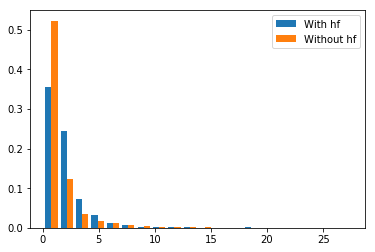

In [94]:
patient_hf = df_static.loc[df_static['heart_failure']==1].index.values
signal_hf = df_binned.loc[df_binned['enc_id'].isin(patient_hf), signal_name].dropna()
signal_no_hf = df_binned.loc[~df_binned['enc_id'].isin(patient_hf), signal_name].dropna()
plt.hist([signal_hf, signal_no_hf], bins=20, density=True, label=['With hf', 'Without hf'])
plt.legend()

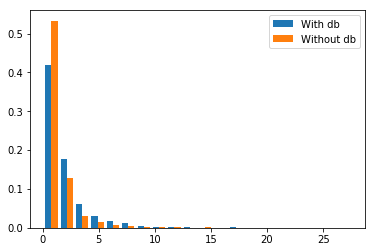

In [95]:
patient_db = df_static.loc[df_static['diabetes']==1].index.values
signal_db = df_binned.loc[df_binned['enc_id'].isin(patient_db), signal_name].dropna()
signal_no_db = df_binned.loc[~df_binned['enc_id'].isin(patient_db), signal_name].dropna()
plt.hist([signal_db, signal_no_db], bins=20, density=True, label=['With db', 'Without db'])
plt.legend()

In [49]:
# pct of hf patients who also have some form of kidney disease
hf_kd = df_static.loc[df_static['heart_failure']==1, ['chronic_kidney', 'renal', 'esrd']]
np.count_nonzero(np.count_nonzero(hf_kd, axis=1))/hf_kd.shape[0]

0.5577777777777778

In [50]:
db_kd =  df_static.loc[df_static['diabetes']==1, ['chronic_kidney', 'renal', 'esrd']]
np.count_nonzero(np.count_nonzero(db_kd, axis=1))/db_kd.shape[0]

0.41002277904328016

In [51]:
with_dialysis = df_binned_with_treatment.groupby('enc_id').filter(lambda x: np.count_nonzero(x['dialysis']) > 0)
#df_static.loc[with_dialysis['enc_id'].unique()]

(array([1.594e+03, 5.450e+02, 1.350e+02, 5.000e+01, 4.600e+01, 2.400e+01,
        8.000e+00, 7.000e+00, 8.000e+00, 7.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.1  ,  1.371,  2.642,  3.913,  5.184,  6.455,  7.726,  8.997,
        10.268, 11.539, 12.81 , 14.081, 15.352, 16.623, 17.894, 19.165,
        20.436, 21.707, 22.978, 24.249, 25.52 ]),
 <a list of 20 Patch objects>)

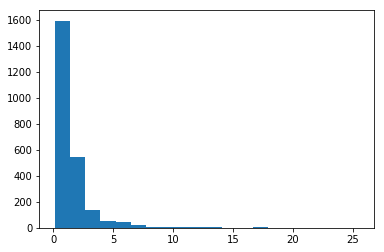

In [52]:
# the mean of signal values for each individual
signal_mean = df_binned.groupby('enc_id').apply(lambda x: np.mean(x[signal_name].values[np.where(np.invert(np.isnan(x[signal_name])))[0]]))
plt.hist(signal_mean, bins=20)

In [53]:
# patients with no treatment given
no_treatment = df_binned.groupby('enc_id').filter(lambda x: np.nonzero(x.loc[:, list(treatment_names.keys())].apply(lambda y: np.count_nonzero(y)))[0].shape[0]==0)
# standard deviation of signal values for patients with no treatment given
signal_std_no_treatment = no_treatment.groupby('enc_id').apply(lambda x: np.std(x[signal_name]))
# number of patients with no treatment given
signal_std_no_treatment.shape[0]

934

0.2649350994992941

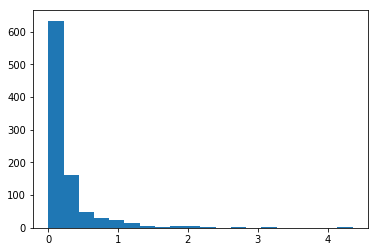

In [54]:
plt.hist(signal_std_no_treatment, bins=20)
# mean of the std
# should approx. transition noise?
np.mean(signal_std_no_treatment)

In [55]:
# patient with heart failure
patient_hf = df_static['heart_failure'].index[df_static['heart_failure'].nonzero()]
df_patient_hf = df_binned.loc[df_binned['enc_id'].isin(patient_hf)]
# patient with heart failure AND received diuretics
df_patient_hf_diuretic = df_patient_hf.groupby('enc_id').filter(lambda x: np.count_nonzero(x['diuretic'])> 0)

In [56]:
# for a given treatment time point, find the time point of the most recent observation PRIOR to 
# the treatment time point
def find_most_recent_obs_before_treatment(treatment_time, obs_times):
    min_index = np.argmin(np.absolute(obs_times-treatment_time))
    if obs_times[min_index] >= treatment_time:
        min_index -= 1
    return obs_times[min_index]

In [57]:
# percentage of decreasing (or increasing) effect of a single treatment at a single past time point e.g. the second
# day before among treatment given to all patients in df
def single_treatment_single_effect(df, treatment, past_time_point, decrease=False):
    patients = df['enc_id'].unique()
    total_num_effect = 0 # total number of treatment that has the desired effect
    # total number of treatment being considered, i.e. at the given past time point for a valid signal measurement
    total_num = 0
    for patient in patients:
        df_patient = df.loc[df['enc_id']==patient]
        treatment_time = np.nonzero(df_patient[treatment])[0]
        treatment_effect = []
        # time points w/ valid observation
        obs_times = np.where(np.invert(np.isnan(df_patient[signal_name].values)))[0]
        # for each observation, if there is a treatment given at the time point in question
        # the treatment effect is estimated by the difference between the current observation
        # and the MOST RECENT observation PRIOR to the time point when the treatment is given
        for i in obs_times:
            curr_obs = df_patient[signal_name].values[i]
            if i-past_time_point in treatment_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   :
                prev_obs_time = find_most_recent_obs_before_treatment(i-past_time_point, obs_times)
                prev_obs = df_patient[signal_name].values[prev_obs_time]
                treatment_effect.append(curr_obs-prev_obs)
                #print('obs time {}'.format(i))
                #print('treatment effect {}'.format(curr_obs-prev_obs))
        treatment_effect = np.array(treatment_effect)
        if decrease:
            total_num_effect += np.where(treatment_effect < 0)[0].shape[0]
        else:
            total_num_effect += np.where(treatment_effect > 0)[0].shape[0]
        total_num += treatment_effect.shape[0]
    if total_num == 0:
        return np.nan
    else:
        return total_num_effect / total_num

In [58]:
# run single_treatment_single_effect on a list of treatments for all of num_past_effects
def multiple_treatment_multiple_effect(df, treatments, decrease=False):
    for treatment in treatments:
        for i in range(1, num_past_effects+1):
            pct = single_treatment_single_effect(df, treatment, i, decrease)
            if decrease:
                effect = 'decreasing'
            else:
                effect = 'increasing'
            print('percentage of {} that has {} effect between the past {} and {} hrs: {}'.format
                  (treatment, effect, (i-1)*bin_size_num, i*bin_size_num, pct))

In [59]:
#multiple_treatment_multiple_effect(df_binned_with_treatment, ['diuretic', 'nephrotoxic_drugs', 'ace_i', 'arb', 
#                                                              'interference_drugs'], decrease=False)

In [60]:
#multiple_treatment_multiple_effect(df_binned_with_treatment, ['dialysis', 'interference_drugs'], decrease=True)

### Convert to np.array for Model Use

In [61]:
# maximum number of bins for an individual
# necessary if convert dataframe to np array
max_num_bins = int(max(df_binned.loc[:, 'time']) / timedelta(hours=bin_size_num)) + 1

In [62]:
max_num_bins

65

In [63]:
# turn static features into np array
c_mtx = df_static.values

In [64]:
# create matrix storing the signal observations
# shape is (number of patient * max_num_bins)
y_list = []
df_binned.groupby('enc_id').apply(lambda x: y_list.append(x.loc[:, signal_name].values))
# for some reason the first group always got appended twice to the list, so delete one
y_list.pop(0)
y_mtx = np.full((len(y_list), max_num_bins), np.nan)
for i, y in enumerate(y_list):
    y_mtx[i, :y.shape[0]] = y

In [65]:
# create matrix storing treatment (after the first observation) information
# shape is (number of patients * max_num_bins * number of treatment categories)
x_list = []
df_binned.groupby('enc_id').apply(lambda x: x_list.append(x.loc[:, list(treatment_names.keys())].values))
x_list.pop(0)
X_mtx = np.zeros((len(x_list), max_num_bins, len(treatment_names.keys())))
for i, x in enumerate(x_list):
    X_mtx[i, :x.shape[0], :] = x

In [66]:
# create matrix storing treatment (before the first observation) information
# shape is (number of patients * num_past_effects * number of treatment categories)
x_prev_list = []
binned_treatment_prev.groupby('enc_id').apply(lambda x: x_prev_list.append(x.loc[:, list(treatment_names.keys())].values))
x_prev_list.pop(0)
X_prev_mtx = np.zeros((len(x_prev_list), num_past_effects, len(treatment_names.keys())))
for i, x in enumerate(x_prev_list):
    X_prev_mtx[i, :x.shape[0], :] = x

In [67]:
np.savez('../Data/'+signal_name+'_preprocessed_data', y_mtx=y_mtx, X_mtx=X_mtx, X_prev_mtx=X_prev_mtx, c_mtx=c_mtx)

### Model Training

In [68]:
em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, 0, train_pct=training_pct, single_effect=single_effect)

In [69]:
%%time
em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = X_prev_mtx, single_effect=single_effect)
em.run_EM(2000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
57 iterations before params converge
CPU times: user 7min 42s, sys: 47.5 ms, total: 7min 42s
Wall time: 7min 42s


In [70]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))
print('initial state variance: {}'.format(em.sigma_0))
print('transition noise: {}'.format(em.sigma_1))
print('observation noise: {}'.format(em.sigma_2))

Coefficient for dialysis: [-1.24373829 -0.89872749 -0.20902346 -0.4215063 ]
Coefficient for nephrotoxic_drugs: [-0.03349585 -0.05744091 -0.03225861 -0.04468311]
Coefficient for interference_drugs: [-0.50972091  0.54442859 -0.57013971  0.43693122]
Coefficient for diuretic: [-0.04367394 -0.10434684 -0.00935436 -0.00099602]
Coefficient for ace_i: [-0.14280888 -0.079936    0.0050792  -0.05291842]
Coefficient for arb: [-0.00396668  0.0167957   0.02324246 -0.04441852]
Coefficient for chronic_kidney: 1.2874509227441815
Coefficient for kidney_cancer: 0.5558421031628413
Coefficient for sickle_cell: 0.8703267601620003
Coefficient for renal: 0.36792365791127696
Coefficient for esrd: 5.054614249742019
Coefficient for diabetes: -0.0060595063165200785
Coefficient for heart_failure: -0.1859378591042274
Coefficient for age: -0.002955753741388636
Coefficient for gender: 0.3186957484379254
Coefficient for admit_weight: 0.002928835478064677
initial state variance: 0.0037654611647195842
transition noise: 

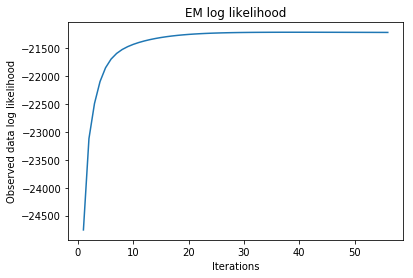

In [71]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

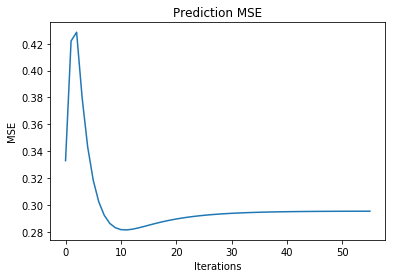

In [72]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE')
plt.show()

In [73]:
# return the index in array a whose element is not in b
def not_in(a, b):
    index = []
    for i, ele in enumerate(a):
        if ele not in b:
            index.append(i)
    return np.array(index)

have_treatment_index = not_in(df_binned['enc_id'].unique(), no_treatment['enc_id'].unique())

Patient 952


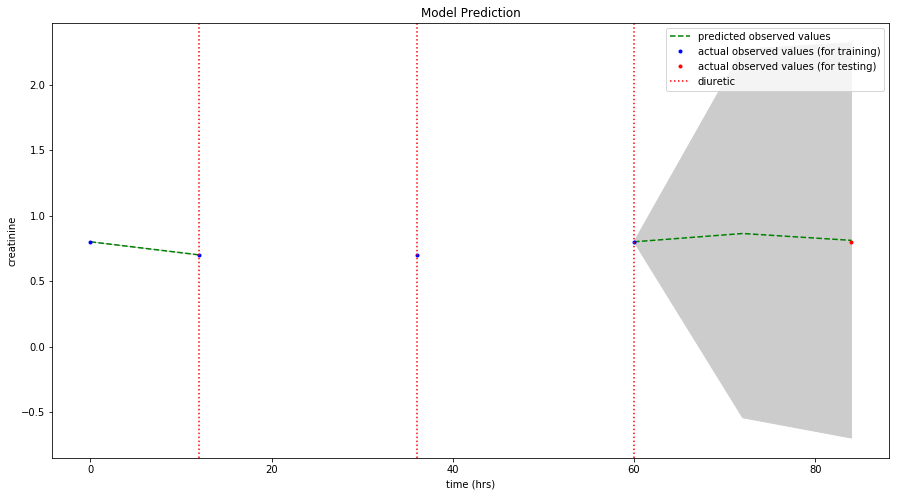

Patient 1135


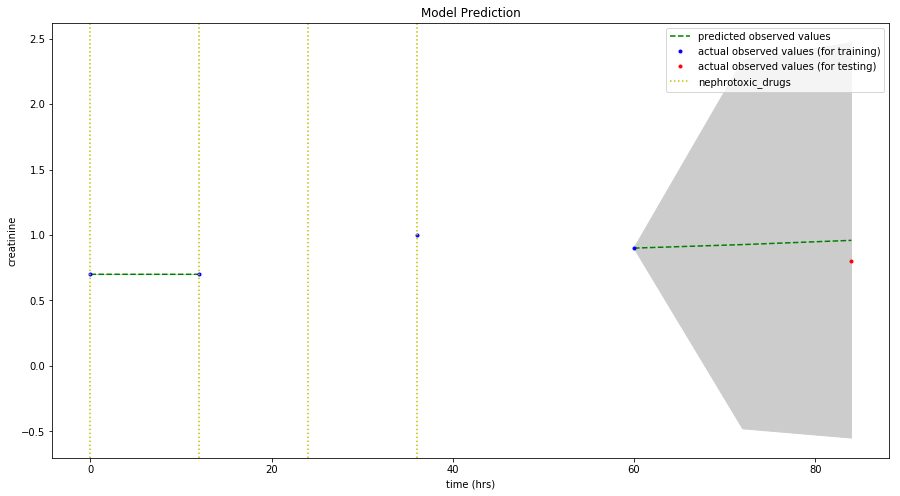

Patient 2113


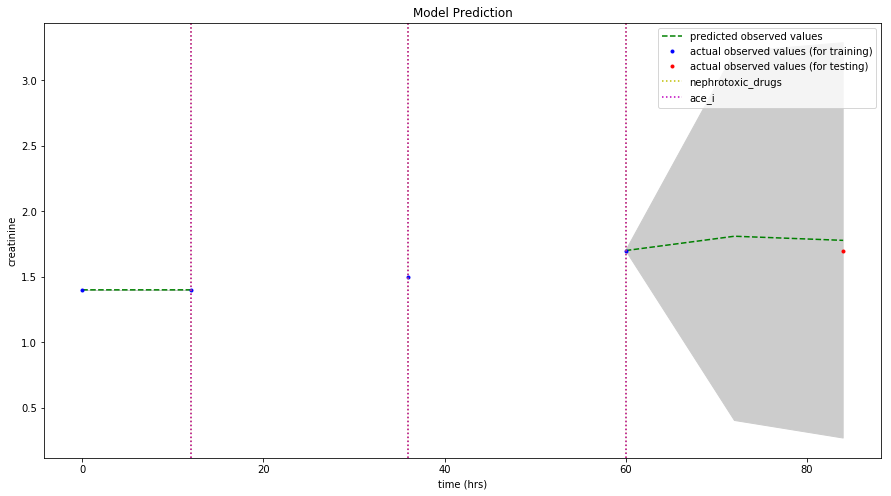

Patient 1576


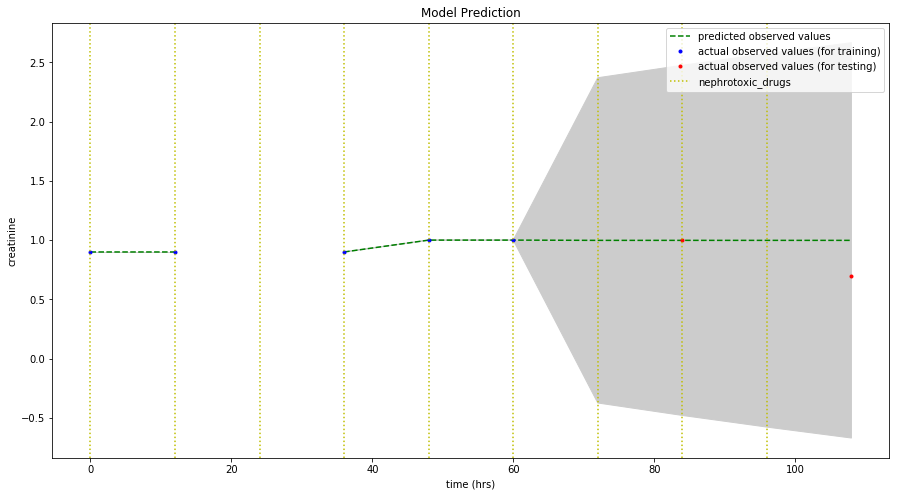

Patient 2340


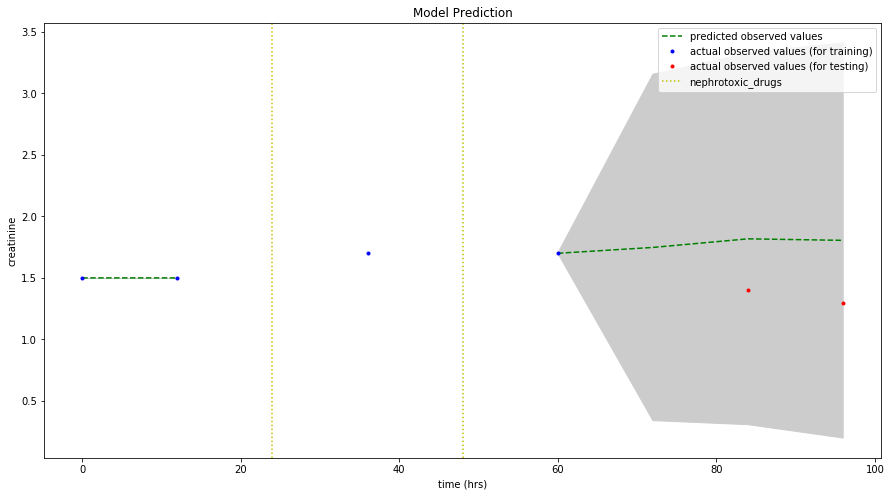

Patient 1997


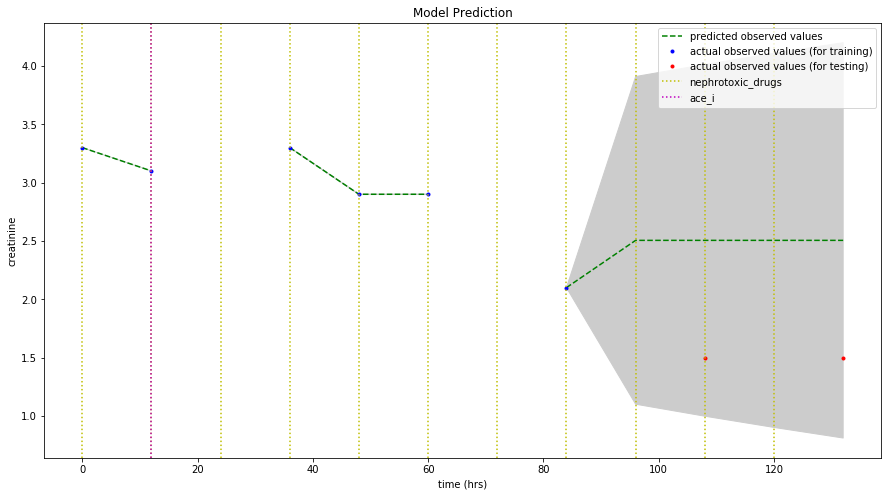

Patient 1847


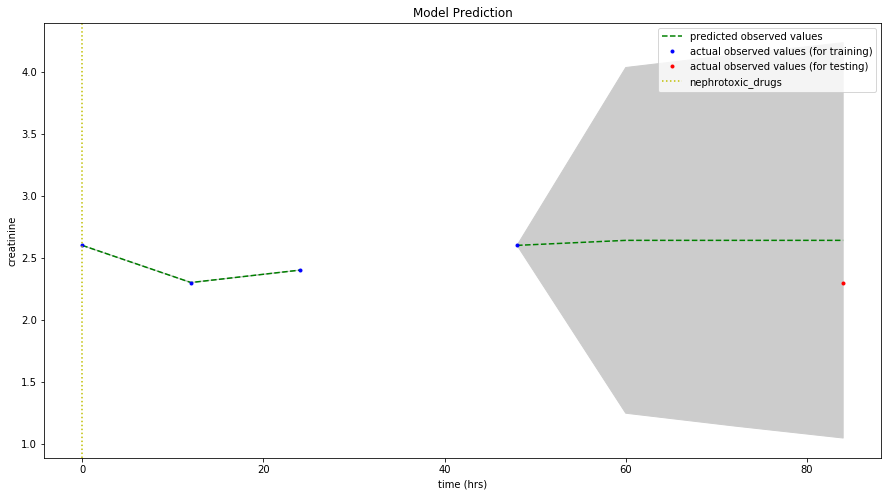

Patient 1268


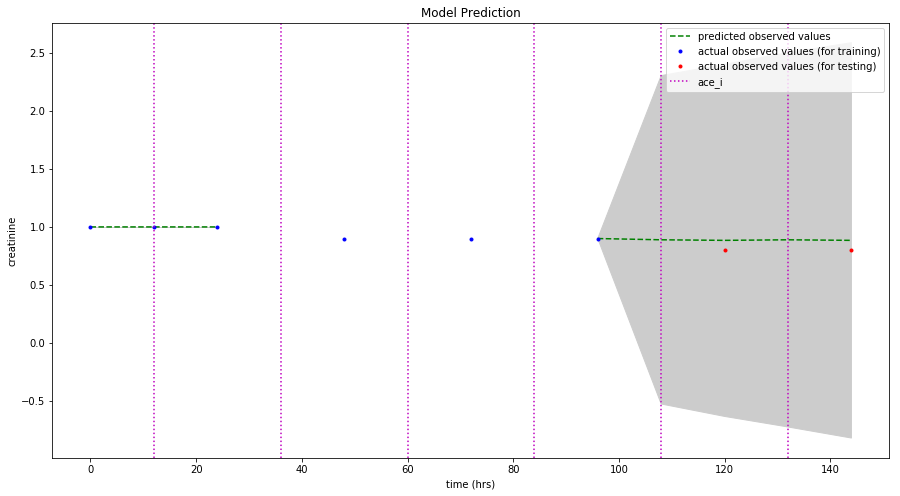

Patient 1860


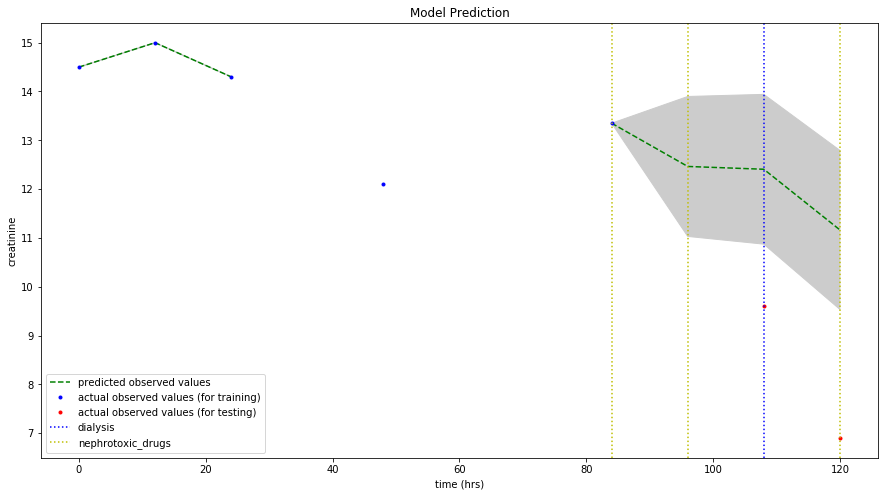

Patient 2431


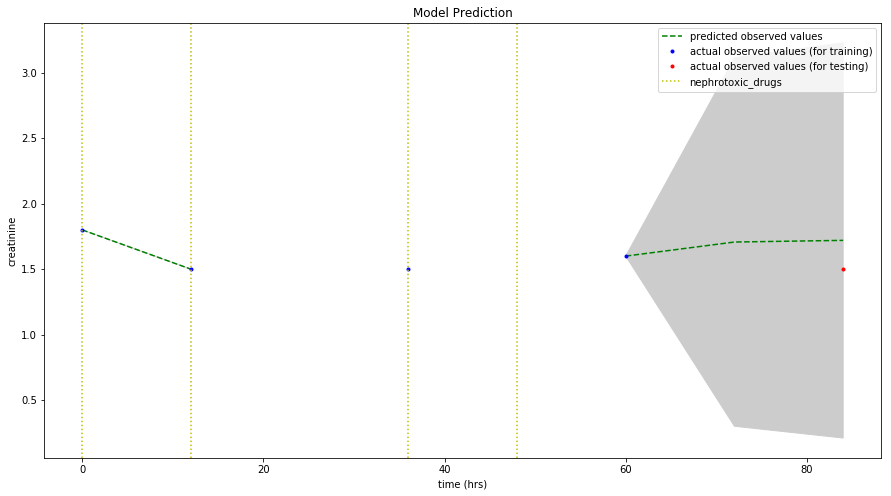

Patient 1227


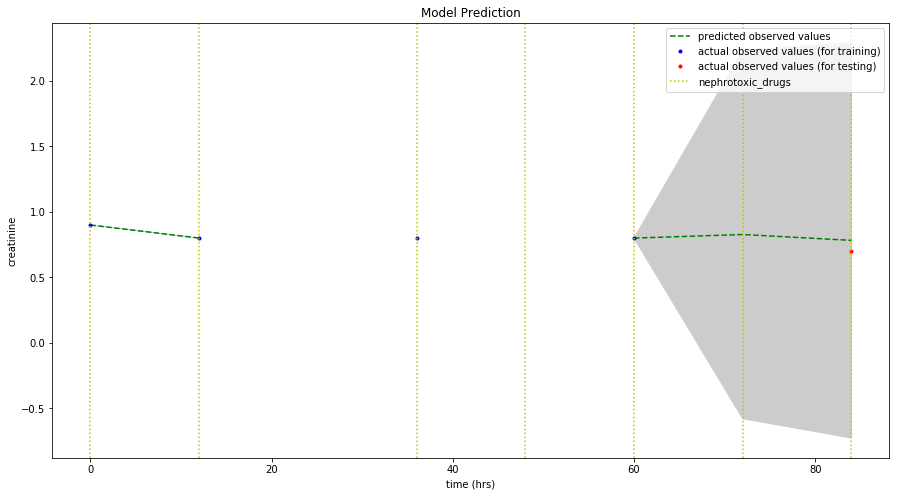

Patient 1027


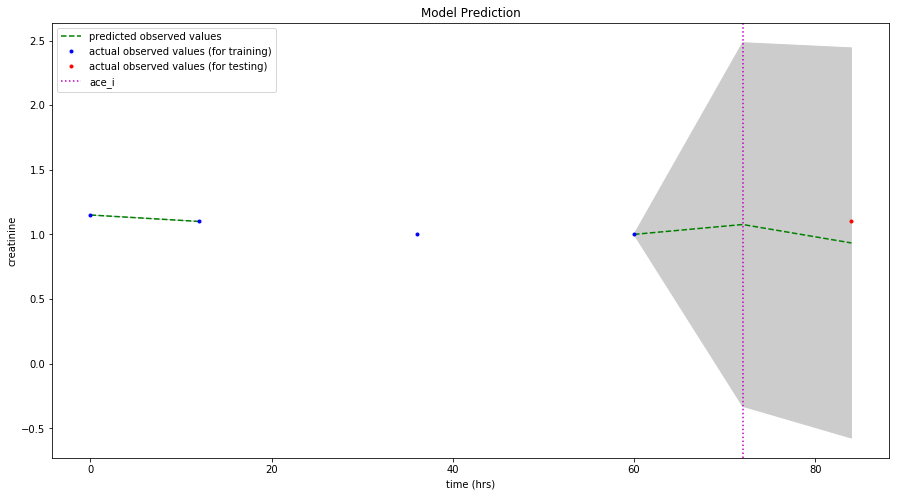

Patient 283


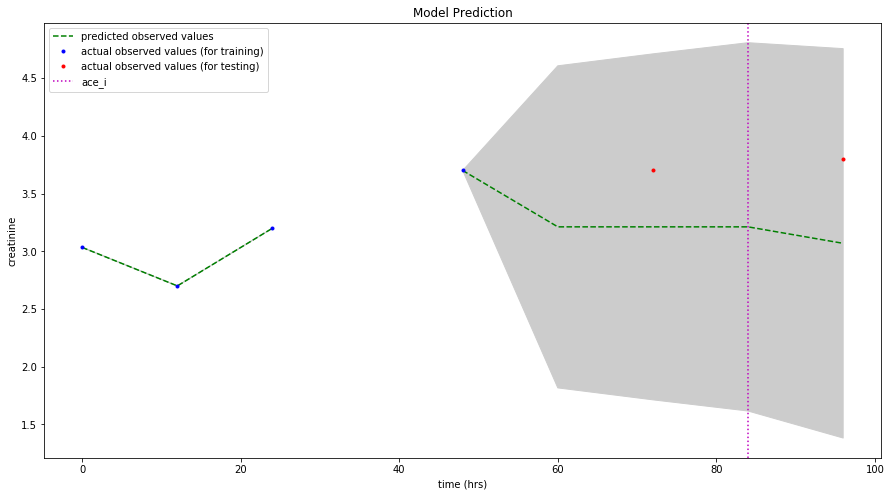

Patient 511


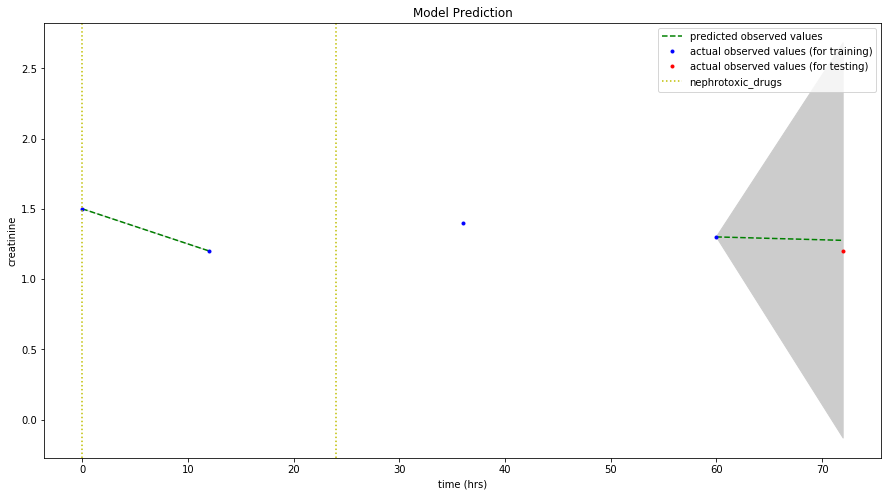

Patient 1083


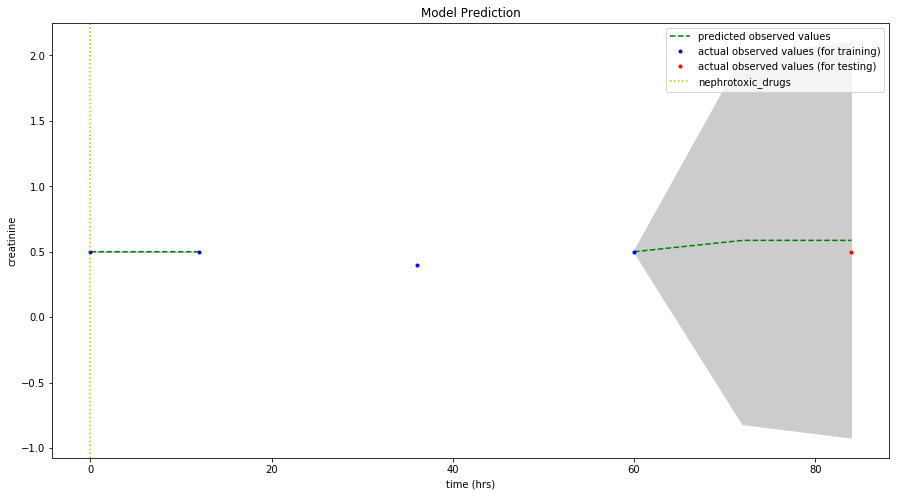

Patient 987


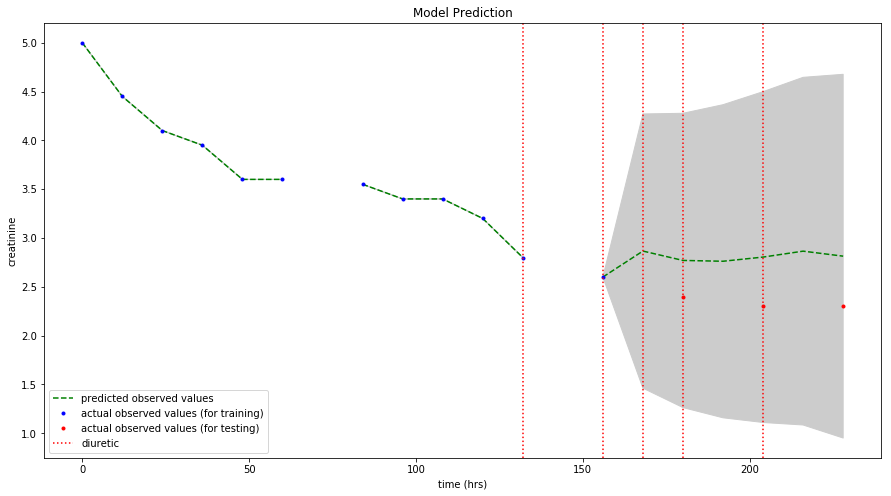

Patient 1895


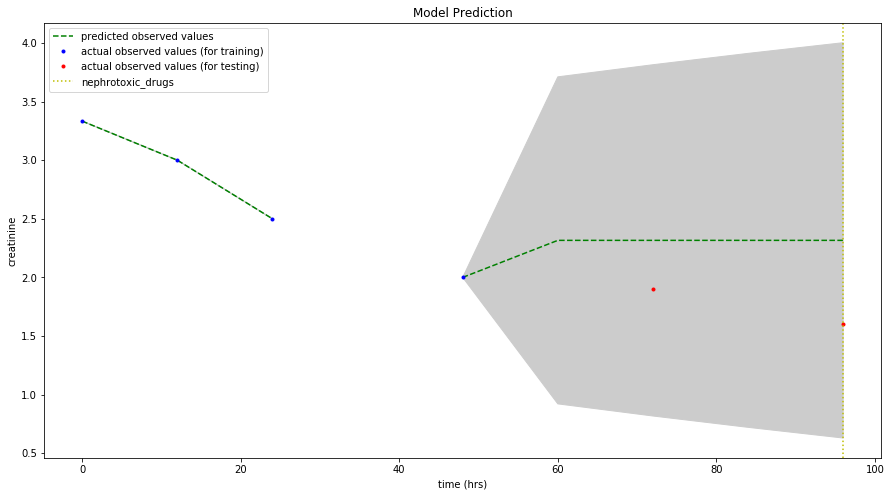

Patient 513


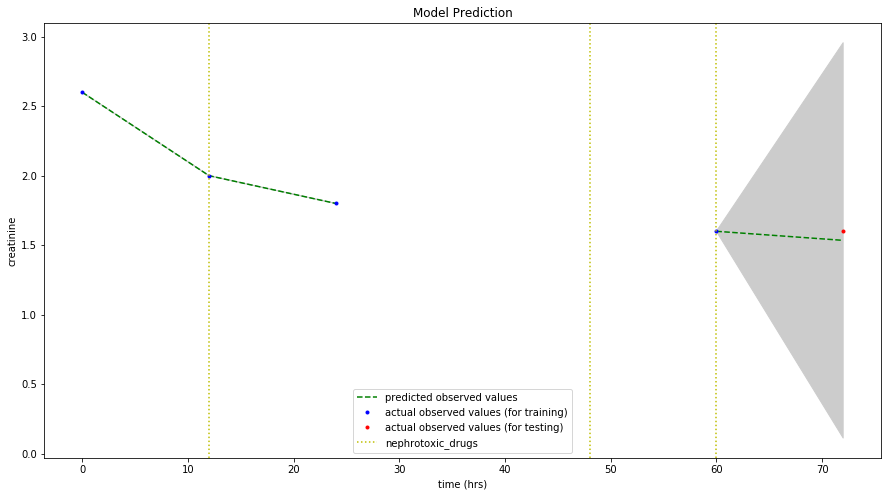

Patient 1244


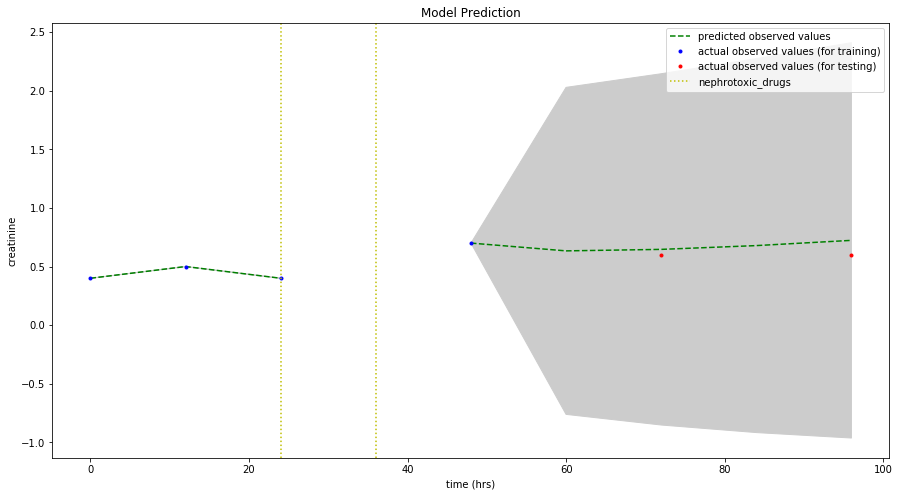

Patient 1119


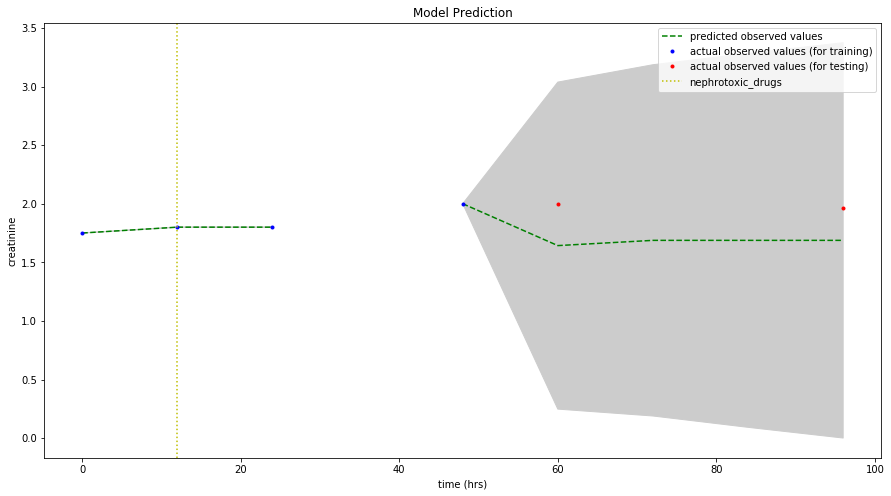

In [81]:
random_patients = np.random.choice(have_treatment_index, size=20, replace=False)
for i in random_patients:
    plot(em, i, bin_size_num, signal_name, treatment_types=list(treatment_names.keys()))

### Future Improvements
* for now, signals and treatments are stored as np array whose shape is determined by the maximum number of bins an individual has. This is to accomodate the existing code in EM.py, but the resulting matrix has lots of extra nans(in the case of signal) and zeros(in the case of treatments), which could be address by changing the data structure used in the EM.py code